In [1]:
import librosa
import numpy as np
from scipy.signal import get_window 
import matplotlib.pyplot as plt
%matplotlib widget

from my_windowing import my_windowing

wave_files = [
    "Audio/phone.wav",
    "Audio/speech1.wav",
    # "Audio/speech2.wav",
]

In [2]:
def plot_signal(title: str, signal: np.ndarray, sr: int):
    time = np.arange(0, len(signal)) / sr

    # create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid(True)

def compute_stft(
        v_signal: np.ndarray, 
        fs: int, 
        frame_length: int, 
        frame_shift: int, 
        v_analysis_window: np.ndarray) : #-> [np.ndarray (m_stft), np.ndarray (v_freq), np.ndarray (v_time)]:
    """
    Input:
    - v_signal vector containing the time domain signal
    - fs sampling rate in Hz
    - frame_length frame length in milliseconds
    - frame_shift frame shift in milliseconds
    - v_analysis_window vector that contains the spectral analysis window (This vector should have the same length as the frames, i.e., frame_length in samples.)
    Output:
    - m_stft a matrix which stores the complex short-time spectra in each row
    - v_freq a vector which contains the frequency axis (in units of Hertz) corresponding to the computed spectra
    - v_time time steps around which a frame is centered (as in previous exercise)
    """
    samples_per_frame = int(fs * frame_length / 1000)
    if len(v_analysis_window) != samples_per_frame:
        raise ValueError("v_analysis_window invalid length")
    
    # 1. Split the time domain signal into overlapping blocks
    m_frames, v_time = my_windowing(v_signal, fs, frame_length, frame_shift)

    # calculate v_freq
    v_freq = fs * (np.arange(samples_per_frame/2 + 1) / samples_per_frame)
    
    # 2. Apply the analysis window to each segment of the time domain signal
    m_frames *= v_analysis_window
    
    # 3. Use the fft function provided by np.fft to compute the DFT for each windowed segment
    dft = np.fft.fft(m_frames, axis=1)
    
    # 4. Only keep the lower half of the spectrum and remove the upper half
    num_freq_bins = dft.shape[1]
    # Make sure that the frequency bin at the Nyquist frequency is still included
    if num_freq_bins % 2 == 0:  # Even number of bins
        dft = dft[:, :num_freq_bins//2 + 1]
    else:  # Odd number of bins
        dft = dft[:, :(num_freq_bins + 1)//2]
    
    # 5. Store the transformed frames in the rows of the output matrix m_stft
    m_stft = dft

    # Test
    rfft = np.fft.rfft(m_frames, axis=1)
    np.testing.assert_array_almost_equal(m_stft, rfft)

    return m_stft, v_freq, v_time

# y, sr = librosa.load(wave_files[0], sr=None)

# samples_per_frame = int(sr * 32 / 1000)
# v_analysis_window = get_window("hann", samples_per_frame, True)

# m_stft, v_freq, v_time = compute_stft(y, sr, 32, 8, v_analysis_window)


*Why are the computed spectra complex conjugate symmetric?*

Complex Conjugate: $3*3+1 = 3*3-i$
Let ... be a real-valued signal with $N$ samples.
Then the DFT series ... has conjugate symmetry:
...


*What may be the advantage of only considering one half of the spectrum?*

The advantage of only considering one half of the spectrum is to reduce redundancy and save memory/storage space. 
Since the negative frequencies are symmetrical to the positive frequencies for a real-valued signal, only storing 
the positive frequencies is sufficient.

*How can you compute the frequency for each spectral bin? How many sampling points does the*

*spectrum have after you removed the mirrored part while including the Nyquist frequency bin?*

The frequency for each spectral bin can be computed using `np.fft.rfftfreq`. After removing 
 the mirrored part while including the Nyquist frequency bin, the spectrum will have `(frame_length_samples // 2) + 1` sampling points.

**2 Spectral analysis**


If not stated otherwise, the following exercises should be performed for both signals.

a) Use your own function to compute the STFT and plot the logarithmic magnitude spectrogram in dB using
the following parameters.

- frame length: 32 ms
- frame shift: 8 ms
- window function: periodic Hann window

The extent option tells matplotlib to use the entries of the vector v_time for the x-axis and v_freq for the
y-axis. Here, the vector v_time contains the time instants for each block / each spectrum and the vector
v_freq contains the frequency bin information.

- Why is the magnitude plotted in dB? 
- Why is it reasonable to introduce a lower limit? 
- What is the lower limit in the command given above in dB?

b) Identify the voiced, unvoiced and silence segments in the spectrogram of the speech signal by eye.

- Describe their appearance and what distinguishes them. Is it possible to identify the different voicing types more easily in comparison to the time domain representation?

c) Produce the same plot as in a) but this time using a frame length corresponding to 8 ms and a frame shift of 2 ms. Further, create a plot for a frame length of 128 ms and a frame shift of 32 ms. 

- How well can you distinguish single sinusoidal components? Short impulses? Explain the influence of the different parameter settings.

d) Only for the speech signal estimate the fundamental frequency using the auto-correlation-based method of the last exercise session. Plot the estimated fundamental frequency onto the spectrogram. The parameter setting should be the one used in a). This can be achieved calling matplotlib.pyplot.plot on the the same axis instance (variable named ax in the code snippet above).

- Do the estimated fundamental frequencies follow the harmonic structures in the spectrogram? You may also want to plot higher harmonics by multiplying your estimated fundamental frequencies with a positive integer value. This way, you can see the precision of the estimated frequencies more precisely.


In [3]:
def estimate_fundamental_frequencies(v_signal, sampling_rate, frame_length_ms=32, frame_shift_ms=16):
    # Step a: Split the signal into frames
    frames, frame_times = my_windowing(v_signal, sampling_rate, frame_length_ms, frame_shift_ms)
    
    fundamental_freqs = []
    
    # Step b: Compute ACF for each frame and step d: Estimate fundamental frequency
    for frame in frames:
        # ACF via convolution
        acf = np.convolve(frame, frame[::-1], mode='full')
        
        # Step c: Focus on non-negative lags
        acf = acf[len(acf)//2:]
        
        # Convert frequency range to corresponding lag range
        min_lag = sampling_rate // 400  # Maximum frequency
        max_lag = sampling_rate // 80   # Minimum frequency
                
        # Step d: Identify peak within the lag range corresponding to 80 Hz to 400 Hz
        peak_lag = np.argmax(acf[min_lag:max_lag]) + min_lag
        fundamental_freq = sampling_rate / peak_lag
        fundamental_freqs.append(fundamental_freq)
    return (np.array(fundamental_freqs), frame_times)


def plot_log_magnitude(title: str, m_stft: np.ndarray, v_freq: np.ndarray, v_time: np.ndarray, ff: tuple | None = None):
    fig = plt.figure()
    fig.set_figwidth(12)
    ax = fig.add_subplot(111)
    ax.set_ylabel("frequency [Hz]")
    ax.set_xlabel("time [s]")
    im = ax.imshow(
        10 * np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10 ** (-15))),
        cmap="viridis",
        origin="lower",
        extent=[v_time[0], v_time[-1], v_freq[0], v_freq[-1]],
        aspect="auto",
    )
    colorbar = fig.colorbar(im, orientation="vertical", pad=0.05)
    colorbar.set_label("dB")

    if ff:
        ax.plot(ff[1], ff[0] * 2, "r")

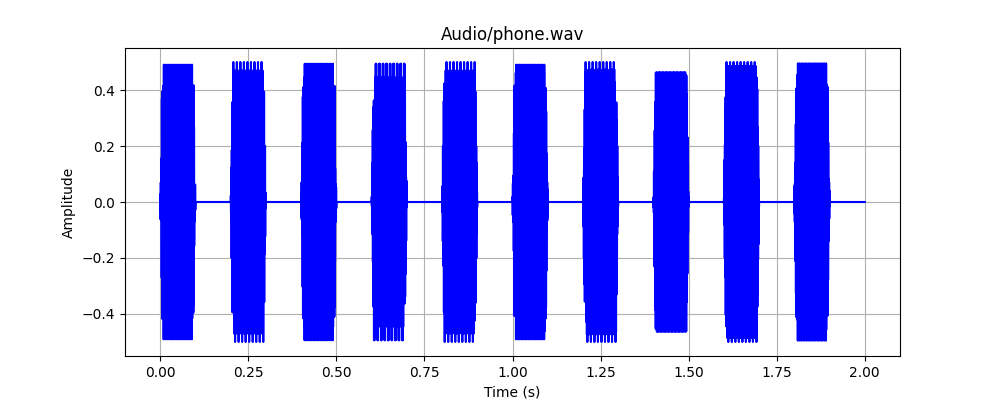

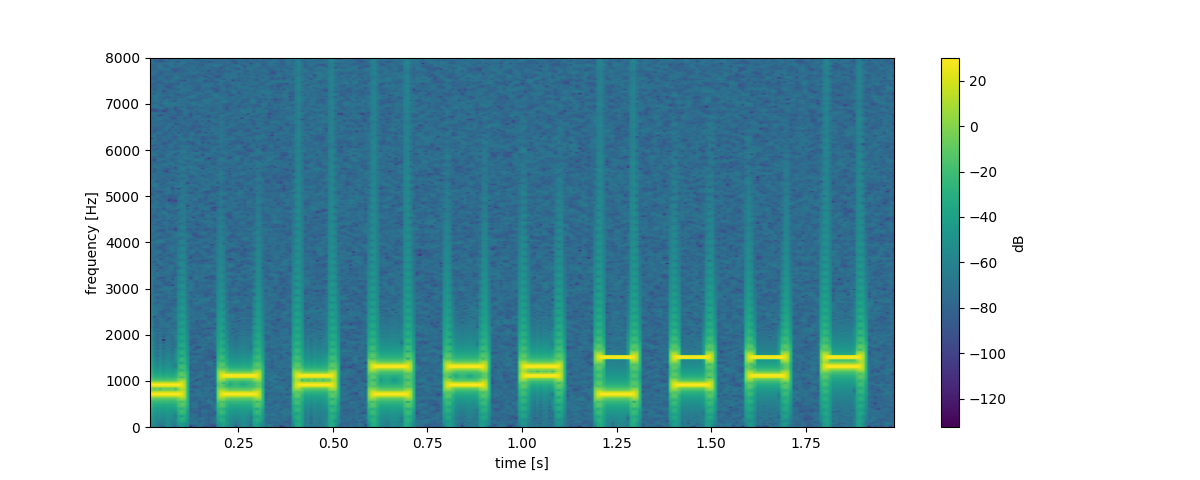

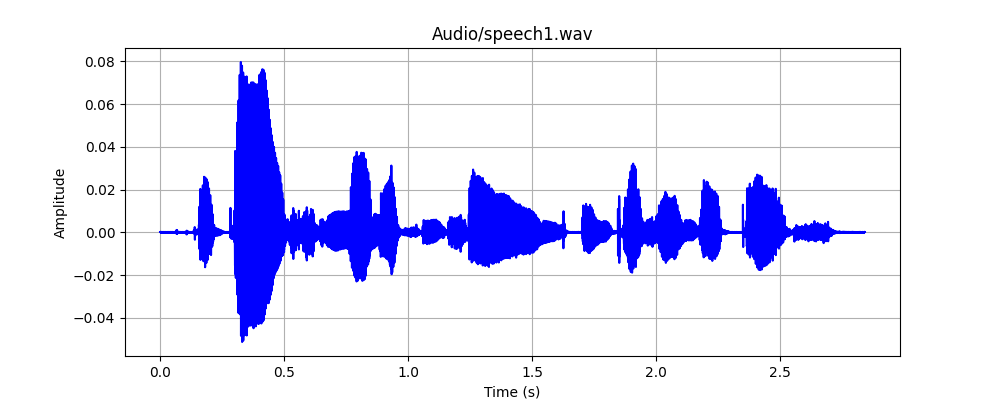

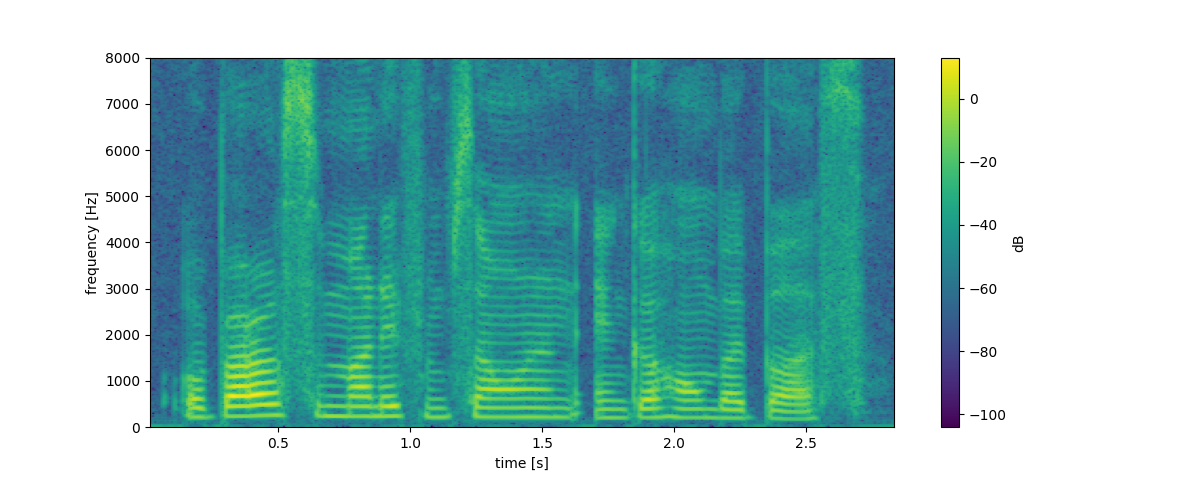

In [5]:
plt.close()

frame_length_ms = 32
frame_shift_ms = 8

for filename in wave_files:
    y, sr = librosa.load(filename, sr=None)

    num_samples = int(sr * 32 / 1000)
    v_analysis_window = get_window("hann", num_samples, True)

    m_stft, v_freq, v_time = compute_stft(y, sr, 32, 8, v_analysis_window)
    plot_signal(filename, y, sr)
    plot_log_magnitude(filename, m_stft, v_freq, v_time)



> Why is the magnitude plotted in dB? 
- More accurate representation of human hearing (on a logarithmic scale)

> Why is it reasonable to introduce a lower limit? 
- we are using $10^-15$ as a lower limit because 

> What is the lower limit in the command given above in dB?
- s.o.

> Describe their [voiced, unvoiced and silence segments] appearance and what distinguishes them. Is it possible to identify the different voicing types more easily in comparison to the time domain representation?
- silence: blue
- unvoiced: no single, clear frequencies can be determined
- voiced: you can clearly determine the frequencies at which the vocal cords are vibrating



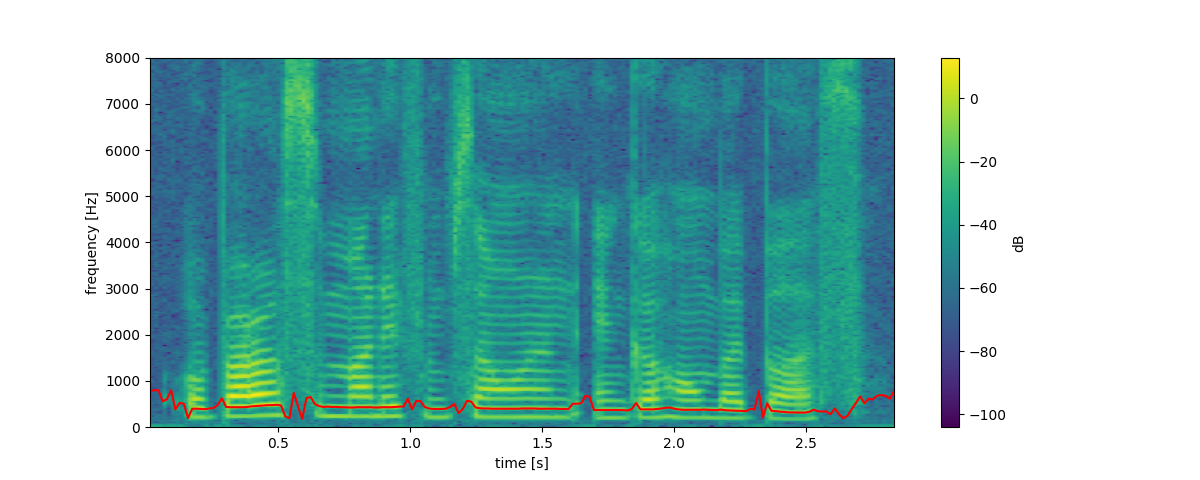

In [4]:
plt.close()

def plot_with_ff(filename, frame_length_ms, frame_shift_ms):
    y, sr = librosa.load(filename, sr=None)

    title = f"frame length: {frame_length_ms} | frame shift: {frame_shift_ms}"
    num_samples = int(sr * frame_length_ms / 1000)
    v_analysis_window = get_window("hann", num_samples, True)

    m_stft, v_freq, v_time = compute_stft(y, sr, frame_length_ms, frame_shift_ms, v_analysis_window)

    ff = estimate_fundamental_frequencies(y, sr, frame_length_ms, frame_shift_ms)

    plot_log_magnitude(title, m_stft, v_freq, v_time, ff)

# c) Produce the same plot as in a) but this time using a frame length corresponding to 8 ms and a frame shift of 2 ms
plot_with_ff(wave_files[1], 32, 16)
#    Further, create a plot for a frame length of 128 ms and a frame shift of 32 ms. 
# plot_with_ff(wave_files[0], 128, 32)


> How well can you distinguish single sinusoidal components? Short impulses? Explain the influence of the different parameter settings.
- short frames decrease the frequency resolution
- long frames increase frequency resolution but introduce "smearing"

d) Only for the speech signal estimate the fundamental frequency using the auto-correlation-based method of the last exercise session. Plot the estimated fundamental frequency onto the spectrogram. The parameter setting should be the one used in a). This can be achieved calling matplotlib.pyplot.plot on the the same axis instance (variable named ax in the code snippet above).

- Do the estimated fundamental frequencies follow the harmonic structures in the spectrogram? You may also want to plot higher harmonics by multiplying your estimated fundamental frequencies with a positive integer value. This way, you can see the precision of the estimated frequencies more precisely.


**3 Synthesis from the STFT domain (Inverse STFT)**

Use the provided Python function `compute_istft()` to synthesize a time-domain signal using overlap-add. The function has the following signature:
```python
def compute_istft (m_stft: np.ndarray, fs: int, frame_shift: int, v_synthesis_window: np.ndarray) -> np.ndarray (v_signal):
```
The input and output parameters have the following meaning:
- `m_stft` matrix containing the STFT spectra which have been generated using the function from Section 1.
- `fs the` sampling rate in Hz
- `frame_shift` frame shift in milliseconds used for the frames in `m_stft`
- `v_synthesis_window` vector containing a synthesis window function
- `v_signal` vector which contains the synthesized time domain signal

Check if the provided function works correctly with the following signal` v_test_signal = np.ones(2048)`. Assume the sampling rate is 16 kHz.

1. Generate the STFT of `v_test_signal` using your function from Section 1 with a frame length of 32 ms and a frame shift of 16 ms. Employ a $\sqrt{Hann}$-window as analysis window. This window can be obtained by applying `np.sqrt` to the previously generated Hann-window.
2. Resynthesize the signal using the compute_istft function. Use the periodic $\sqrt{Hann}$-window also as synthesis
window. For frame_length and frame_shift, use the same values that you employed for generating the STFT. Finally, plot the synthesized signal.
    - Is it possible to perfectly reconstruct the input signal? Are there parts where a perfect reconstruction is not possible when a $\sqrt{Hann}$-window is used as analysis and synthesis window?
    - What happens, when you unset the parameter periodic in the window generation? Which error can you observe in the reconstructed signal? Explain the difference in the window function which causes this behavior.

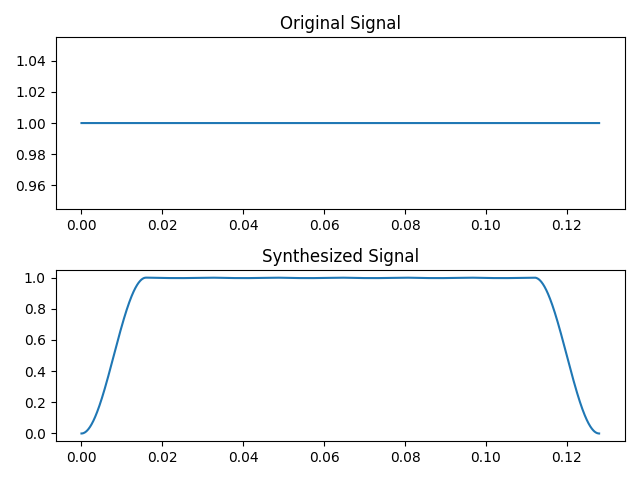

In [64]:
from code_exercise2 import compute_istft

plt.close()

v_test_signal = np.ones(2048)
sr = 16000

frame_length_ms = 32
frame_shift_ms = 16

num_samples = int(sr * 32 / 1000)
v_sqrt_hann_window = np.sqrt(get_window("hann", num_samples, False))

m_stft, v_freq, v_time = compute_stft(v_test_signal, sr, frame_length_ms, frame_shift_ms, v_sqrt_hann_window)

v_istft = compute_istft(m_stft, sr, frame_shift_ms, v_sqrt_hann_window)

t1 = np.linspace(0, len(v_test_signal)/sr, len(v_test_signal))
t2 = np.linspace(0, len(v_istft)/sr, len(v_istft))

plt.figure()

ax1 = plt.subplot(2, 1, 1)
ax1.plot(t1, v_test_signal)
ax1.set_title('Original Signal')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(t2, v_istft)
ax2.set_title('Synthesized Signal')

plt.tight_layout()
plt.show()



> Is it possible to perfectly reconstruct the input signal? Are there parts where a perfect reconstruction is not possible when a $\sqrt{Hann}$-window is used as analysis and synthesis window?
- not possible
- the first and last 0.015 seconds of the input signal are distorted

> What happens, when you unset the parameter periodic in the window generation? Which error can you observe in the reconstructed signal? Explain the difference in the window function which causes this behavior.
- Setting the parameter `fftbins` to False does not result in a change of the reconstructed signal.


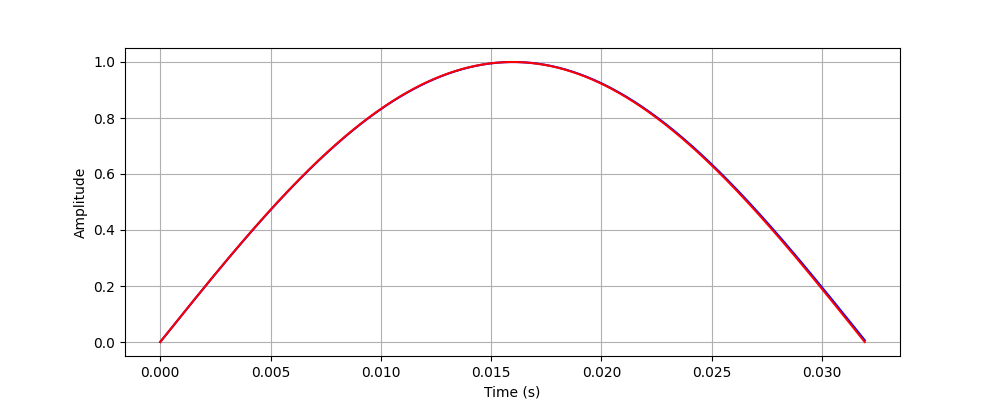

In [61]:
num_samples = int(sr * 32 / 1000)
v_sqrt_hann_window = np.sqrt(get_window("hann", num_samples, True))
v_sqrt_hann_window_symm = np.sqrt(get_window("hann", num_samples, False))

time = np.arange(0, len(v_sqrt_hann_window)) / sr

# create the plot
plt.figure(figsize=(10, 4))
plt.plot(time, v_sqrt_hann_window, color='b')
plt.plot(time, v_sqrt_hann_window_symm, color='r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)